# Welcome to the SAGAN fit tutorial

We are lucky, WFIRST give us a preview event of its work. 
Let's have a look to your choice lightcurve first.

In [1]:
## First import the required libraries
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time

lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels

First, let 's have a look to this event!

<IPython.core.display.Javascript object>


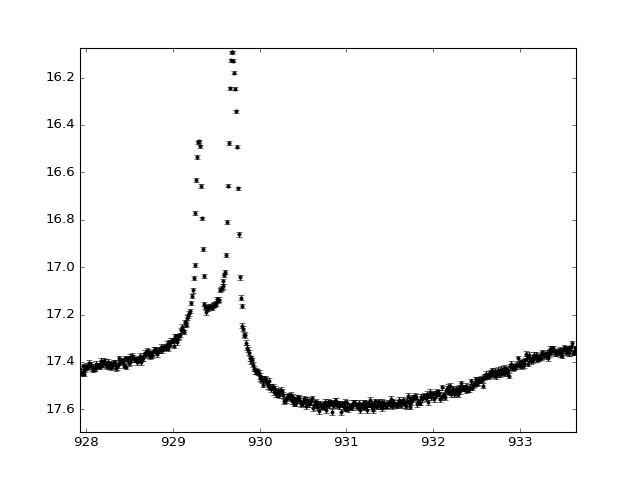

In [2]:
WFIRST_data = np.loadtxt('./WFIRST_binary_SAGAN.dat')[::1]

### Lets have a look on what it is exactly :
figure1 = plt.figure()
plt.errorbar(WFIRST_data[:,0]-2460000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
figure1.show()


In [3]:
### First, let's find some properties of the anomaly

## time of the anomaly occurs
t_anomaly = 2460930

## duration of the anomaly.
delta_t = 4.0

## amplitude of the anomaly
delta_I =17.6-16.2

delta_A = 10**((delta_I)/2.5)




### Create an event object. You can choose the name and RA,DEC in degrees :

your_event = event.Event()
your_event.name = 'WFIRST binary'


### Let's define the WFIRST observations


### We delete the anomaly for this first fit
good = np.where((WFIRST_data[:,0]<t_anomaly-delta_t) | 
                (WFIRST_data[:,0]>t_anomaly+delta_t))[0]


WFIRST_data_reduce = WFIRST_data[good]

### Plot reject/accept data


wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=WFIRST_data_reduce)

your_event.telescopes.append(wfirst)



Start fit on WFIRST binary, with model PSPL and method LM
check_event  : Everything looks fine, this event can be fitted
initial_guess  : Initial parameters guess SUCCESS
lmarquardt  : Levenberg_marquardt fit SUCCESS
[2460956.853308085, 0.4235797108967089, 60.14808984201651, 5443.201770739473, -0.04720545959255119, 20176.592710352452]


<IPython.core.display.Javascript object>


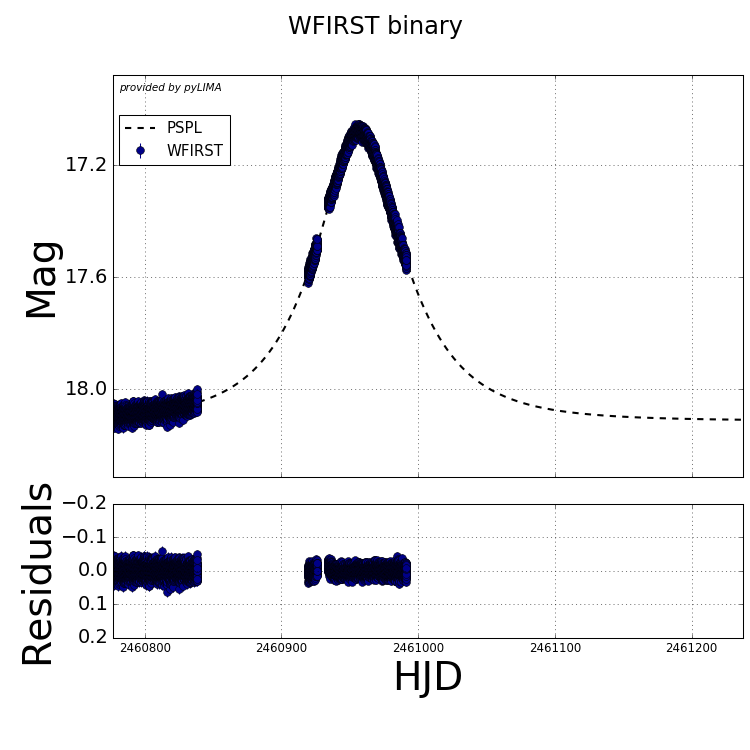

<IPython.core.display.Javascript object>


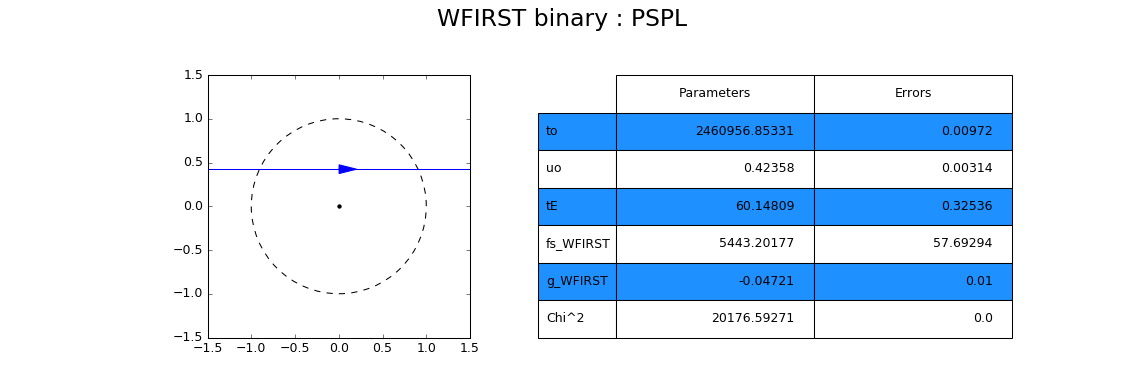

In [4]:
### Let's fit with a Point Source Point Lens model

pspl_model = microlmodels.create_model('PSPL', your_event)
your_event.fit(pspl_model,'LM')
your_event.fits[0].produce_outputs()
plt.show()

Hey, not to bad! Given the short duration of the anomaly and the good PSPL fit, this probably mean our anomaly is due to a planet. 

In [5]:
### Finally, extract PSPL parameters from first fit 
to = your_event.fits[0].outputs.fit_parameters.to
uo = your_event.fits[0].outputs.fit_parameters.uo
tE = your_event.fits[0].outputs.fit_parameters.tE

U_peak  = (uo**2+(t_anomaly-to)**2/tE**2)**0.5


All right! We can then derive some binary parameters using this :

- s = (U_peak +- (U_peak^2+4)^0.5)/2  This is accurate
- rho = delta_t/(2tE) This is NOT accurate
- q = delta_A/2*rho^2 This is NOT accurate

- x_caustic = s - 1/s
- y_caustic_close = 2*q^0.5/(s*(1+s^2)^0.5)
- y_caustic_wide = 0
- gamma = arcsin(uo/U_peak) 
- beta = arcsin(y_caustic/x_caustic)
- alpha = see below This is accurate


But if you more confident with your own derivation, please go ahead and change s,q and rho.

In [6]:
### Let's have s, rho, q and alpha

###Major image deviation
#s = np.abs((U_peak+(U_peak**2+4)**0.5)/2)
###Minor image deviation
s = np.abs((U_peak-(U_peak**2+4)**0.5)/2)


q = (delta_t/(2*tE))**2

rho = delta_t/(2*tE)


x_caustic = s-1/s

if s<1 :
    
    y_caustic = 2*q**0.5/(s*(1+s**2)**0.5)
    
else : 
    
    y_caustic = 0
    
gamma = np.arccos(uo/U_peak)
beta = np.arcsin(y_caustic/x_caustic)

alpha = (np.pi/2-gamma-beta) 


# Geometrical consideration
if s<1 :
    
    if t_anomaly > to:
        
        alpha = np.pi-alpha
else :
    
    if t_anomaly > to:
        alpha = -alpha
        
    else :
        alpha = alpha-np.pi
        
print to
print uo
print tE
print rho
print s,np.log10(s)
print q, np.log10(q)
print alpha


2460956.85331
0.423579710897
60.148089842
0.03325126376
0.738562604642 -0.131612685595
0.00110564654164 -2.95638368818
0.877079840682


OK, enough work for you. We have enough guess to fit the event. To be sure, we gonna use a general solver using differential evolution. But thanks to our guess, we can reduce a lot the parameter space!

In [7]:
### Let's define a binary model, name in pyLIMA is Uniform Source Binary Lens.

binary_model = microlmodels.create_model('USBL', your_event)
binary_model.define_model_parameters()

### Have a look to your guess. Change these parameters if you want 
estimate_parameters = [to, uo, tE, rho, np.log10(s), np.log10(q), alpha]

pyLIMA_parameters = binary_model.compute_pyLIMA_parameters(estimate_parameters)

### we redefine the the data with the anomaly now
wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=WFIRST_data)


model, wfirst_source_flux, wfirst_blend_flux = binary_model.compute_the_microlensing_model(wfirst, pyLIMA_parameters)
model_in_magnitude = 27.4-2.5*np.log10(model)
plt.figure()
plt.errorbar(WFIRST_data[:,0]-2450000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
plt.plot(wfirst.lightcurve_flux[:,0]-2450000, model_in_magnitude)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
### we redfine our event for the final fit. 
your_event = event.Event()
your_event.name = 'WFIRST binary'


### Speed up computations
## we limited high computations only around the anomaly
binary_model.USBL_windows = [t_anomaly-2*delta_t,t_anomaly+2*delta_t]



## we artifically decrease the number of points for speeding up.
## Do not decrease to much the sampling inside your anomaly if it is short.THIS IS CASE SENSITIVE. 
start_anomaly = np.where(WFIRST_data[:,0]<binary_model.USBL_windows[0])[0][-1]
end_anomaly = np.where(WFIRST_data[:,0]>binary_model.USBL_windows[1])[0][0]

light_curve_reduce = np.r_[WFIRST_data[:start_anomaly:32],
                           WFIRST_data[start_anomaly:end_anomaly:8],
                           WFIRST_data[end_anomaly::32]]

#int(delta_t/2+1)
wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=light_curve_reduce)

your_event.telescopes.append(wfirst)



### to boundaries
binary_model.parameters_boundaries[0] = [to-3,to+3]
### uo boundaries
binary_model.parameters_boundaries[1] = [uo-0.1 , uo+0.1]
### tE boundaries
binary_model.parameters_boundaries[2] = [tE-2,tE+2]
### rho boundaries
binary_model.parameters_boundaries[3] = [10**-4,10**-2]
### log_10(s) boundaries
binary_model.parameters_boundaries[4] = [np.log10(s)-0.5,np.log10(s)+0.5]
### log_10(q) boundaries
#binary_model.parameters_boundaries[5] = [-5.60,-3.60]
### alpha boundaries
binary_model.parameters_boundaries[6] = [alpha-1.0,alpha+1.0]

### DE_population_size scale the size of the DE population. More it is, bigger is your chance to find the minima
### but slower it is.
start = time.time()

your_event.fit(binary_model, 'DE',  DE_population_size = 3)
print time.time()-start

#import pdb; pdb.set_trace()
your_event.fits[-1].produce_outputs()
plt.show()


Start fit on WFIRST binary, with model USBL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 37271.8
differential_evolution step 2: f(x)= 37136.8
differential_evolution step 3: f(x)= 36937.5
differential_evolution step 4: f(x)= 36937.5
differential_evolution step 5: f(x)= 36937.5
differential_evolution step 6: f(x)= 36886.9
differential_evolution step 7: f(x)= 36886.9
differential_evolution step 8: f(x)= 36886.9
differential_evolution step 9: f(x)= 36886.9
differential_evolution step 10: f(x)= 36886.9
differential_evolution step 11: f(x)= 36886.9
differential_evolution step 12: f(x)= 36886.9
differential_evolution step 13: f(x)= 36886.9
differential_evolution step 14: f(x)= 36886.9
differential_evolution step 15: f(x)= 36886.9
differential_evolution step 16: f(x)= 36886.9
differential_evolution step 17: f(x)= 36886.9
differential_evolution step 18: f(x)= 36879
differential_evolution step 19: f(x)= 36879
differential_evol